In [1]:
!pip install datasets transformers evaluate
!pip install -U accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 83.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 3.1 MB/s eta 0:00:00


In [2]:
from torch.utils.data import Dataset
from datasets import load_dataset
from tqdm import tqdm
import numpy as np
from torch import nn
import torch
from transformers import AutoTokenizer


In [3]:
dataset = load_dataset("copenlu/answerable_tydiqa")

train_set = dataset["train"]
validation_set = dataset["validation"]

def get_answer_start(row):
  return row["annotations"]["answer_start"][0]

def get_answer(row):
  return row["annotations"]["answer_text"][0]

def get_document(row):
  return row["document_plaintext"]

def get_question(row):
  return row["question_text"]

def oracle(answer, document):
  return answer != "" and answer in document

def row_oracle(row):
  return oracle(get_answer(row), get_document(row))

def get_language(dataset, lang):
  return dataset.filter(lambda x: x["language"] == lang)#[row for row in dataset if row['language'] == lang]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/116067 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13325 [00:00<?, ? examples/s]

In [4]:
train_arabic = get_language(train_set, "arabic")
val_arabic = get_language(validation_set, "arabic")

train_bengali = get_language(train_set, "bengali")
val_bengali = get_language(validation_set, "bengali")

train_indonesian = get_language(train_set, "indonesian")
val_indonesian = get_language(validation_set, "indonesian")

Filter:   0%|          | 0/116067 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13325 [00:00<?, ? examples/s]

Filter:   0%|          | 0/116067 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13325 [00:00<?, ? examples/s]

Filter:   0%|          | 0/116067 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13325 [00:00<?, ? examples/s]

In [5]:
train_arabic_tt = train_arabic.train_test_split(test_size=0.2)
train_bengali_tt = train_bengali.train_test_split(test_size=0.2)
train_indonesian_tt = train_indonesian.train_test_split(test_size=0.2)

In [10]:
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords

bengali_removal_list = list(set(stopwords.words('bengali')))
arabic_removal_list = list(set(stopwords.words('arabic')))
indonesian_removal_list = list(set(stopwords.words('indonesian')))

def remove_stop_words(sentence, stopwords):
  words = sentence.split()
  filtered_words = [word for word in words if word not in stopwords]
  return ' '.join(filtered_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Training

In [ ]:
MODEL = "bert-base-multilingual-cased"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [10]:
def preprocess(row):
    document = remove_stop_words(get_document(row), bengali_removal_list)
    question = remove_stop_words(get_question(row), bengali_removal_list)

    #row["label"] = int(row_oracle(row))
    return tokenizer(question + ' <SEP> ' + document, truncation=True)

In [ ]:
tokenized_train_bn = train_bengali_tt.map(preprocess, remove_columns=train_bengali_tt["train"].column_names)

Map:   0%|          | 0/3823 [00:00<?, ? examples/s]

Map:   0%|          | 0/956 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [14]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):

    logits, labels = eval_pred

    predictions = np.argmax(logits, axis=1)

    return accuracy.compute(predictions=predictions, references=labels)

In [12]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL, num_labels=2
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
training_args = TrainingArguments(

    output_dir="my_awesome_clas_model_bn",

    learning_rate=2e-5,

    per_device_train_batch_size=16,

    per_device_eval_batch_size=16,

    num_train_epochs=4,

    weight_decay=0.01,

    evaluation_strategy="epoch",

    save_strategy="epoch",

    load_best_model_at_end=True,

    push_to_hub=True,

)

trainer = Trainer(

    model=model,

    args=training_args,

    train_dataset=tokenized_train_bn["train"],

    eval_dataset=tokenized_train_bn["test"],

    tokenizer=tokenizer,

    data_collator=data_collator,

    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.433035,0.811715
2,No log,0.364054,0.855649


TrainOutput(global_step=478, training_loss=0.4386754375122581, metrics={'train_runtime': 852.758, 'train_samples_per_second': 8.966, 'train_steps_per_second': 0.561, 'total_flos': 1888972933075200.0, 'train_loss': 0.4386754375122581, 'epoch': 2.0})

# Validation

## Bengali

In [7]:
from transformers import AutoModelForSequenceClassification
tokenizer_bengali = AutoTokenizer.from_pretrained("Axel-0087/my_awesome_clas_model_bn")

model_bengali = AutoModelForSequenceClassification.from_pretrained("Axel-0087/my_awesome_clas_model_bn")

In [12]:
preds = []
labels = []

for row in val_bengali:
  document = remove_stop_words(get_document(row), bengali_removal_list)
  question = remove_stop_words(get_question(row), bengali_removal_list)

  text = question + ' <SEP> ' + document

  inputs = tokenizer_bengali(text, return_tensors="pt", truncation=True)
  with torch.no_grad():
      logits = model_bengali(**inputs).logits
      pred = np.argmax(logits, axis=1)
      preds.append(pred)

  labels.append(row_oracle(row))

In [15]:
accuracy.compute(predictions=preds, references=labels)

{'accuracy': 0.8303571428571429}

## Arabic

In [16]:
from transformers import AutoModelForSequenceClassification
tokenizer_arabic = AutoTokenizer.from_pretrained("Axel-0087/my_awesome_clas_model_ar")

model_arabic = AutoModelForSequenceClassification.from_pretrained("Axel-0087/my_awesome_clas_model_ar")

In [17]:
preds = []
labels = []

for row in val_arabic:
  document = remove_stop_words(get_document(row), arabic_removal_list)
  question = remove_stop_words(get_question(row), arabic_removal_list)

  text = question + ' <SEP> ' + document

  inputs = tokenizer_arabic(text, return_tensors="pt", truncation=True)
  with torch.no_grad():
      logits = model_arabic(**inputs).logits
      pred = np.argmax(logits, axis=1)
      preds.append(pred)

  labels.append(row_oracle(row))

In [18]:
accuracy.compute(predictions=preds, references=labels)

{'accuracy': 0.9227129337539433}

### Indonesian

In [19]:
from transformers import AutoModelForSequenceClassification
tokenizer_indonesian = AutoTokenizer.from_pretrained("Axel-0087/my_awesome_clas_model_in")

model_indonesian = AutoModelForSequenceClassification.from_pretrained("Axel-0087/my_awesome_clas_model_in")

In [20]:
preds = []
labels = []

for row in val_indonesian:
  document = remove_stop_words(get_document(row), indonesian_removal_list)
  question = remove_stop_words(get_question(row), indonesian_removal_list)

  text = question + ' <SEP> ' + document

  inputs = tokenizer_indonesian(text, return_tensors="pt", truncation=True)
  with torch.no_grad():
      logits = model_indonesian(**inputs).logits
      pred = np.argmax(logits, axis=1)
      preds.append(pred)

  labels.append(row_oracle(row))

In [21]:
accuracy.compute(predictions=preds, references=labels)

{'accuracy': 0.8706968933669186}

# Visualization

In [39]:
def get_min_text(val, stoplist, answerable=False):

  min_text = ""
  min_length = 10000
  min_row = {}

  for row in val:
    document = remove_stop_words(get_document(row), stoplist)
    question = remove_stop_words(get_question(row), stoplist)
    text = question + ' <SEP> ' + document

    if len(text) < min_length:
      if (not answerable) or row_oracle(row):
        min_text = text
        min_length = len(text)
        min_row = row

  return min_text, min_row

In [62]:
import matplotlib.pyplot as plt

def visualize_token2token_scores(scores_mat, tokens, fontproperties = None, x_label_name='Head'):
    fig = plt.figure(figsize=(20, 20))

    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(4, 3, idx+1)

        if fontproperties != None:
          for label in ax.get_xticklabels() :
            label.set_fontproperties(fontproperties)

          for label in ax.get_yticklabels() :
            label.set_fontproperties(fontproperties)

        # append the attention weights
        im = ax.imshow(scores, cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(tokens)))
        ax.set_yticks(range(len(tokens)))

        ax.set_xticklabels(tokens, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(tokens, fontdict=fontdict)
        ax.set_xlabel('{} {}'.format(x_label_name, idx+1))

        fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

## Bengali

In [ ]:
from transformers import AutoModel

model = AutoModel.from_pretrained("Axel-0087/my_awesome_clas_model_bn", output_attentions=True)
tokenizer = tokenizer_bengali #AutoTokenizer.from_pretrained("Axel-0087/my_awesome_clas_model")

In [56]:
text, row = get_min_text(val_bengali, bengali_removal_list, answerable=True)
print(row)
print(len(text))

{'question_text': 'প্রত্যেক বাস্তুতন্ত্রে মূলত কয়টি উপাদান থাকে ?', 'document_title': 'বাস্তুতন্ত্র', 'language': 'bengali', 'annotations': {'answer_start': [28], 'answer_text': ['দুটি']}, 'document_plaintext': 'প্রত্যেক বাস্তুতন্ত্রে মূলত দুটি উপাদান রয়েছে, যথা-', 'document_url': 'https://bn.wikipedia.org/wiki/%E0%A6%AC%E0%A6%BE%E0%A6%B8%E0%A7%8D%E0%A6%A4%E0%A7%81%E0%A6%A4%E0%A6%A8%E0%A7%8D%E0%A6%A4%E0%A7%8D%E0%A6%B0'}
95


In [48]:
inputs = tokenizer(text, return_tensors="pt", truncation=True)

outputs = model(**inputs)
with torch.no_grad():
  logits = model_bengali(**inputs).logits
  pred = np.argmax(logits, axis=1)
  print(pred)
attention = outputs[-1]
input_ids = inputs["input_ids"]
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

tensor([1])


In [42]:
output_attentions_all = torch.stack(attention)

In [ ]:
from google.colab import files
files.upload()

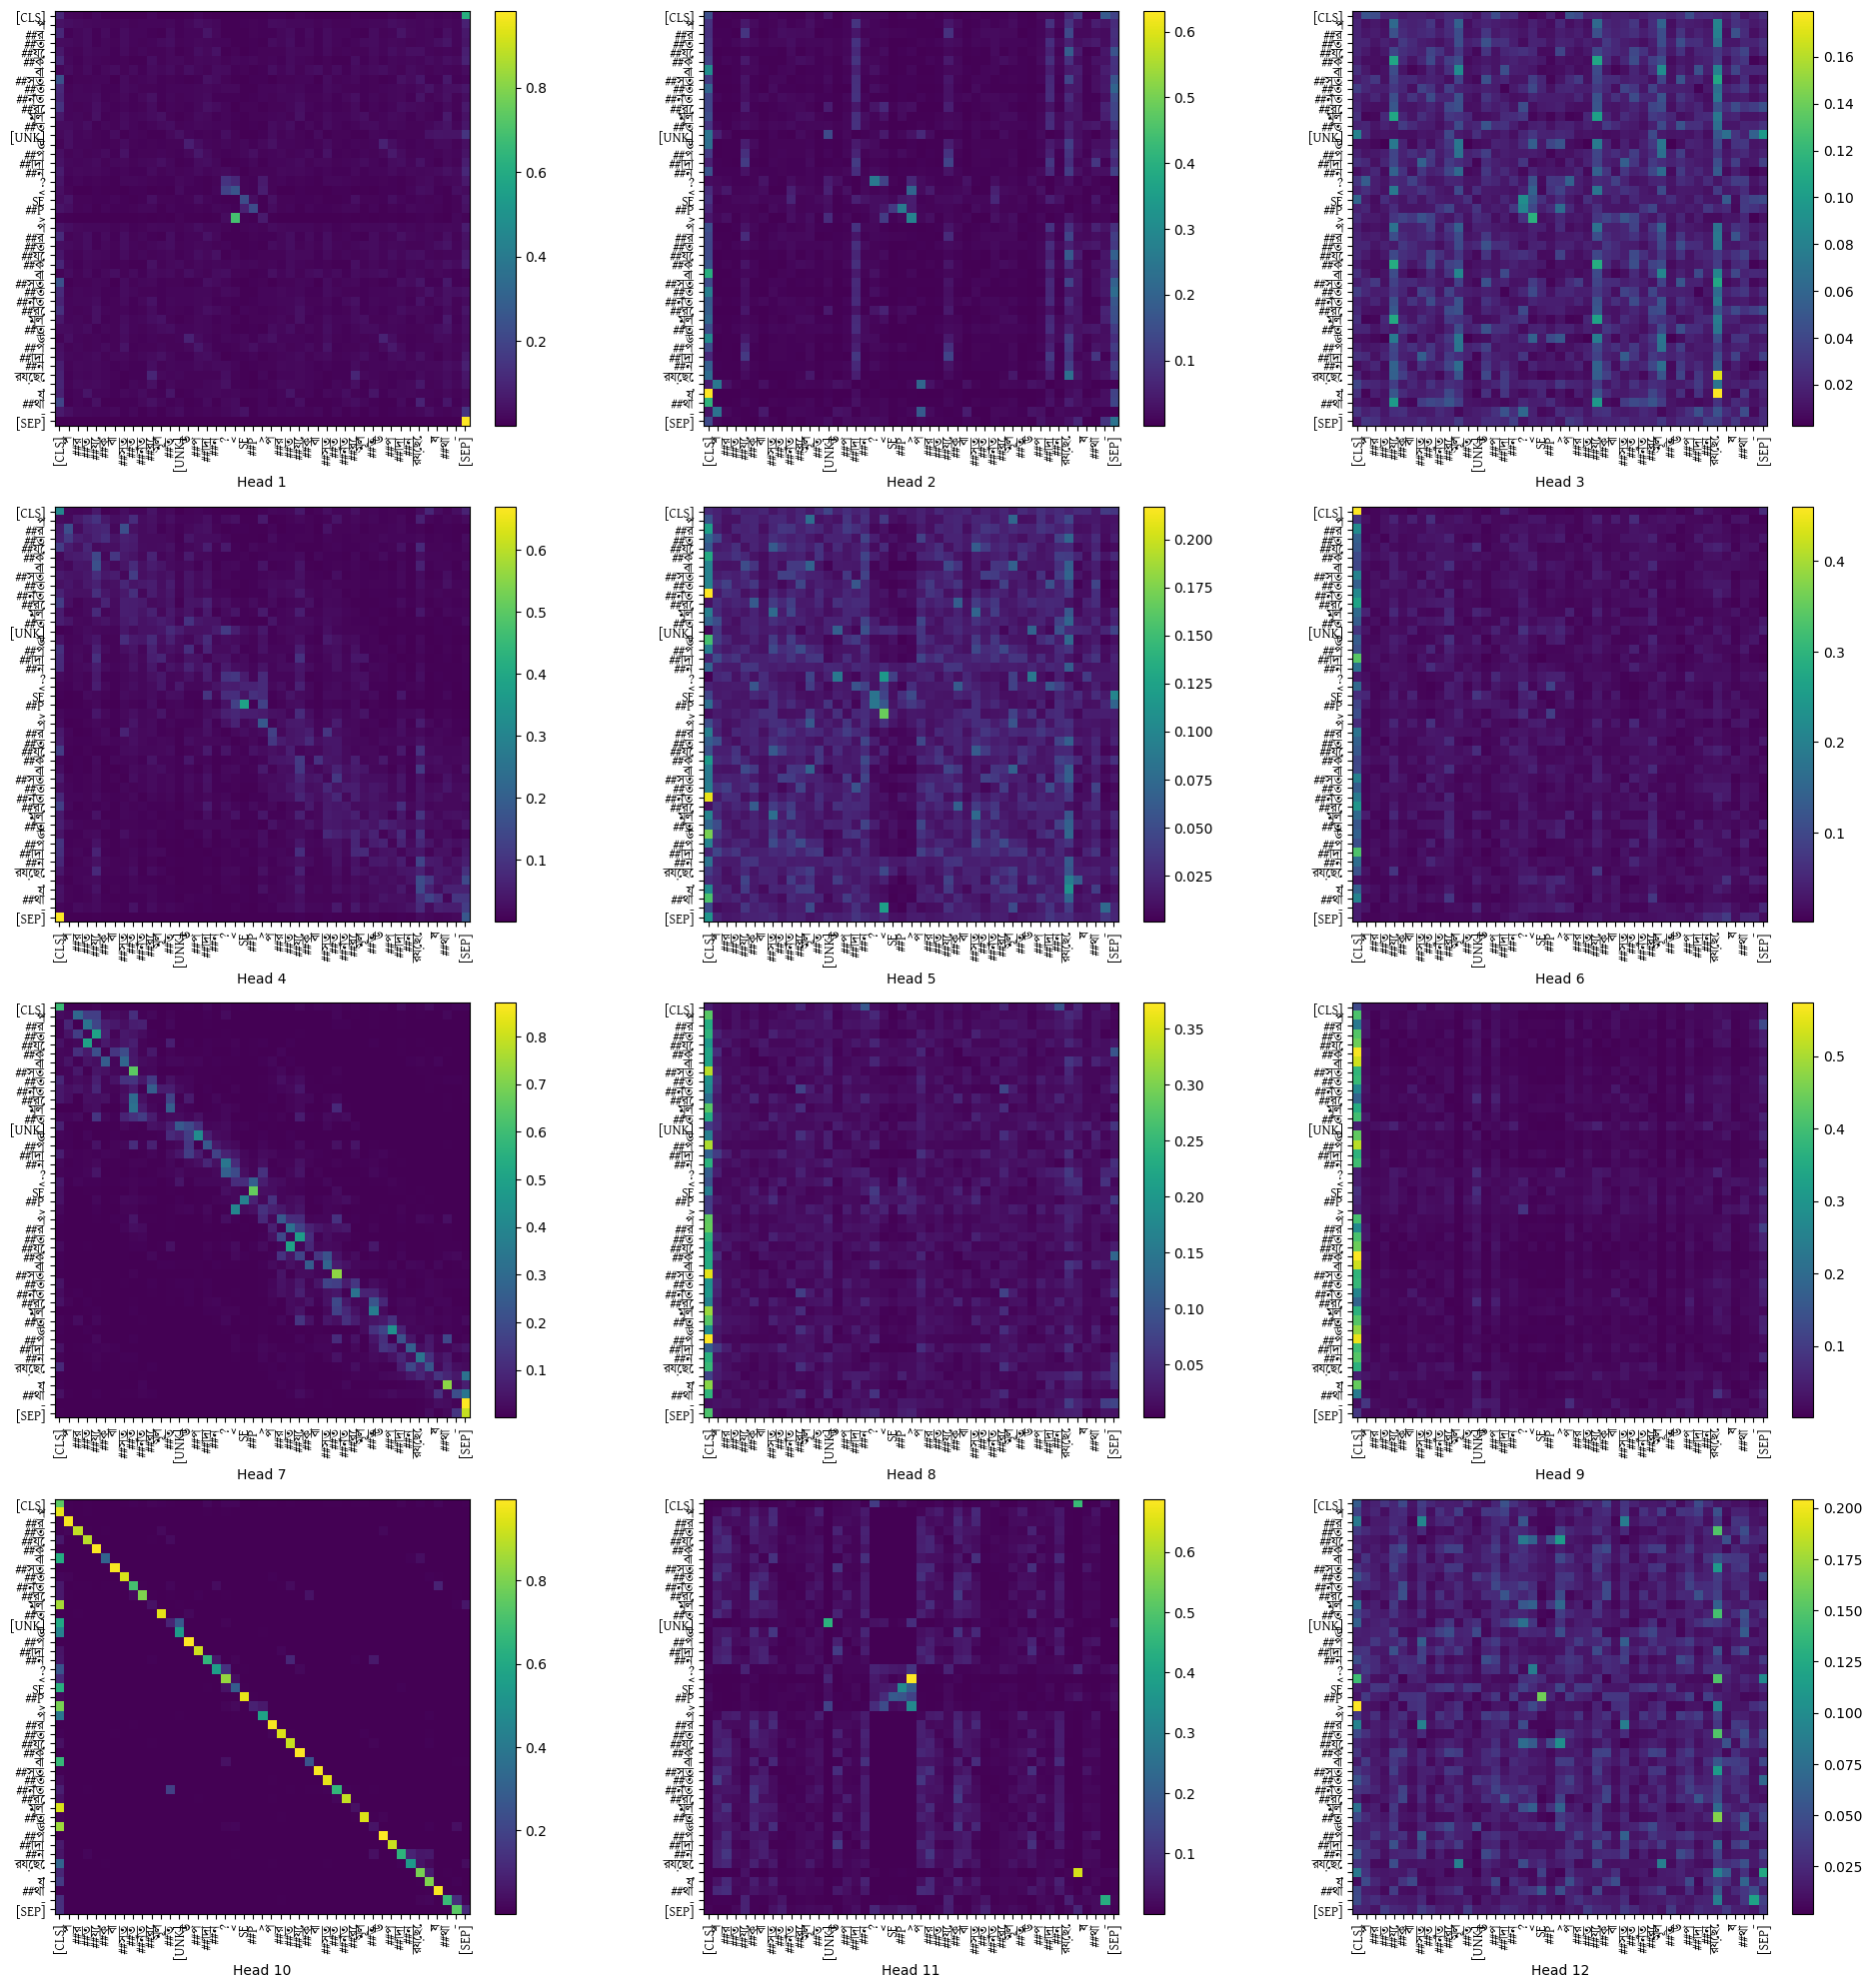

In [55]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

prop = fm.FontProperties(fname='kalpurush.ttf')

visualize_token2token_scores(output_attentions_all[0].squeeze().detach().cpu().numpy(), tokens, fontproperties=prop)

### Arabic

In [57]:
from transformers import AutoModel

model = AutoModel.from_pretrained("Axel-0087/my_awesome_clas_model_ar", output_attentions=True)
tokenizer = tokenizer_arabic

In [58]:
text, row = get_min_text(val_arabic, arabic_removal_list, answerable=True)
print(row)
print(len(text))

{'question_text': 'من هو إدغار ديغا؟', 'document_title': 'إدغار ديغا', 'language': 'arabic', 'annotations': {'answer_start': [14], 'answer_text': ['فنان تشكيلي و رسام و نحات فرنسي']}, 'document_plaintext': '\n\nإدغار ديغا  فنان تشكيلي و رسام و نحات فرنسي.', 'document_url': 'https://ar.wikipedia.org/wiki/%D8%A5%D8%AF%D8%BA%D8%A7%D8%B1%20%D8%AF%D9%8A%D8%BA%D8%A7'}
57


In [65]:
inputs = tokenizer(text, return_tensors="pt", truncation=True)

outputs = model(**inputs)
with torch.no_grad():
  logits = model_arabic(**inputs).logits
  pred = np.argmax(logits, axis=1)
  print(pred)
attention = outputs[-1]
input_ids = inputs["input_ids"]
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

output_attentions_all = torch.stack(attention)

tensor([1])


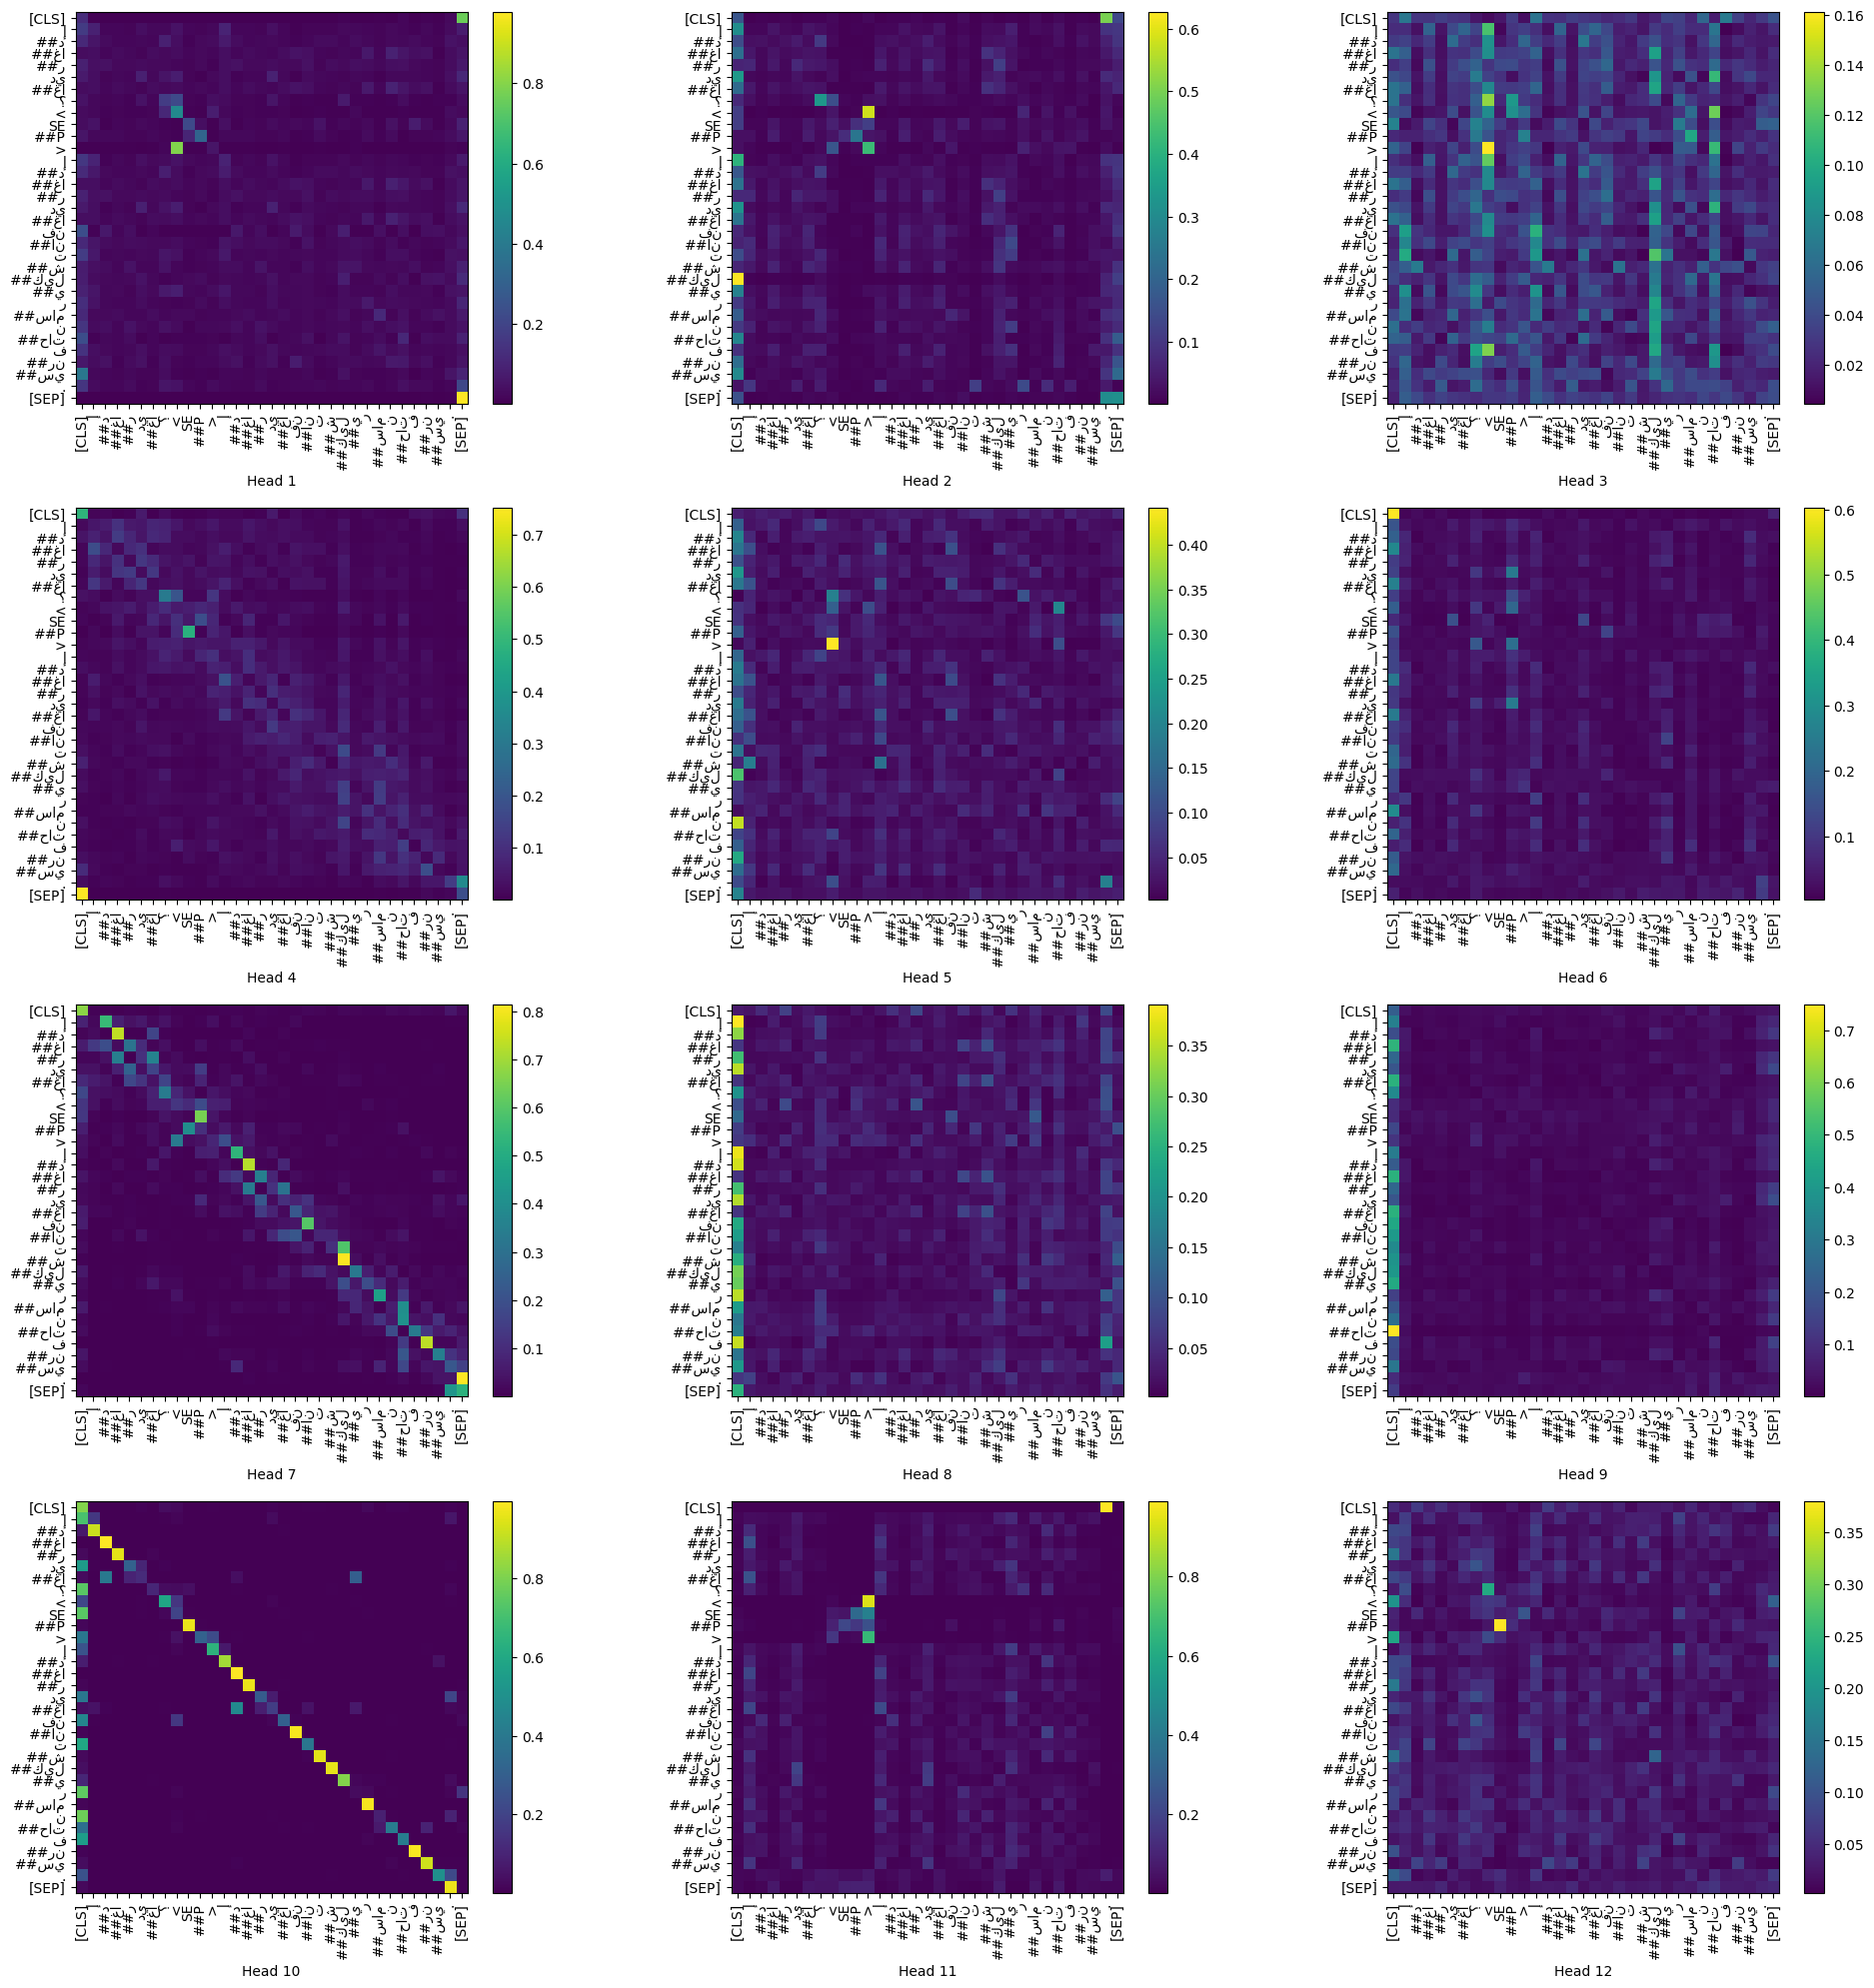

In [63]:
visualize_token2token_scores(output_attentions_all[0].squeeze().detach().cpu().numpy(), tokens)

### Indonesian

In [64]:
model = AutoModel.from_pretrained("Axel-0087/my_awesome_clas_model_in", output_attentions=True)
tokenizer = tokenizer_indonesian

In [68]:
text, row = get_min_text(val_indonesian, indonesian_removal_list, answerable=True)
print(row)
print(len(text))

{'question_text': 'Apa yang dimaksud dengan frekuensi ?', 'document_title': 'Frekuensi', 'language': 'indonesian', 'annotations': {'answer_start': [17], 'answer_text': ['ukuran jumlah putaran ulang per peristiwa dalam satuan detik dengan satuan Hz']}, 'document_plaintext': 'Frekuensi adalah ukuran jumlah putaran ulang per peristiwa dalam satuan detik dengan satuan Hz.', 'document_url': 'https://id.wikipedia.org/wiki/Frekuensi'}
86


In [69]:
inputs = tokenizer(text, return_tensors="pt", truncation=True)

outputs = model(**inputs)
with torch.no_grad():
  logits = model_indonesian(**inputs).logits
  pred = np.argmax(logits, axis=1)
  print(pred)
attention = outputs[-1]
input_ids = inputs["input_ids"]
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

output_attentions_all = torch.stack(attention)

tensor([1])


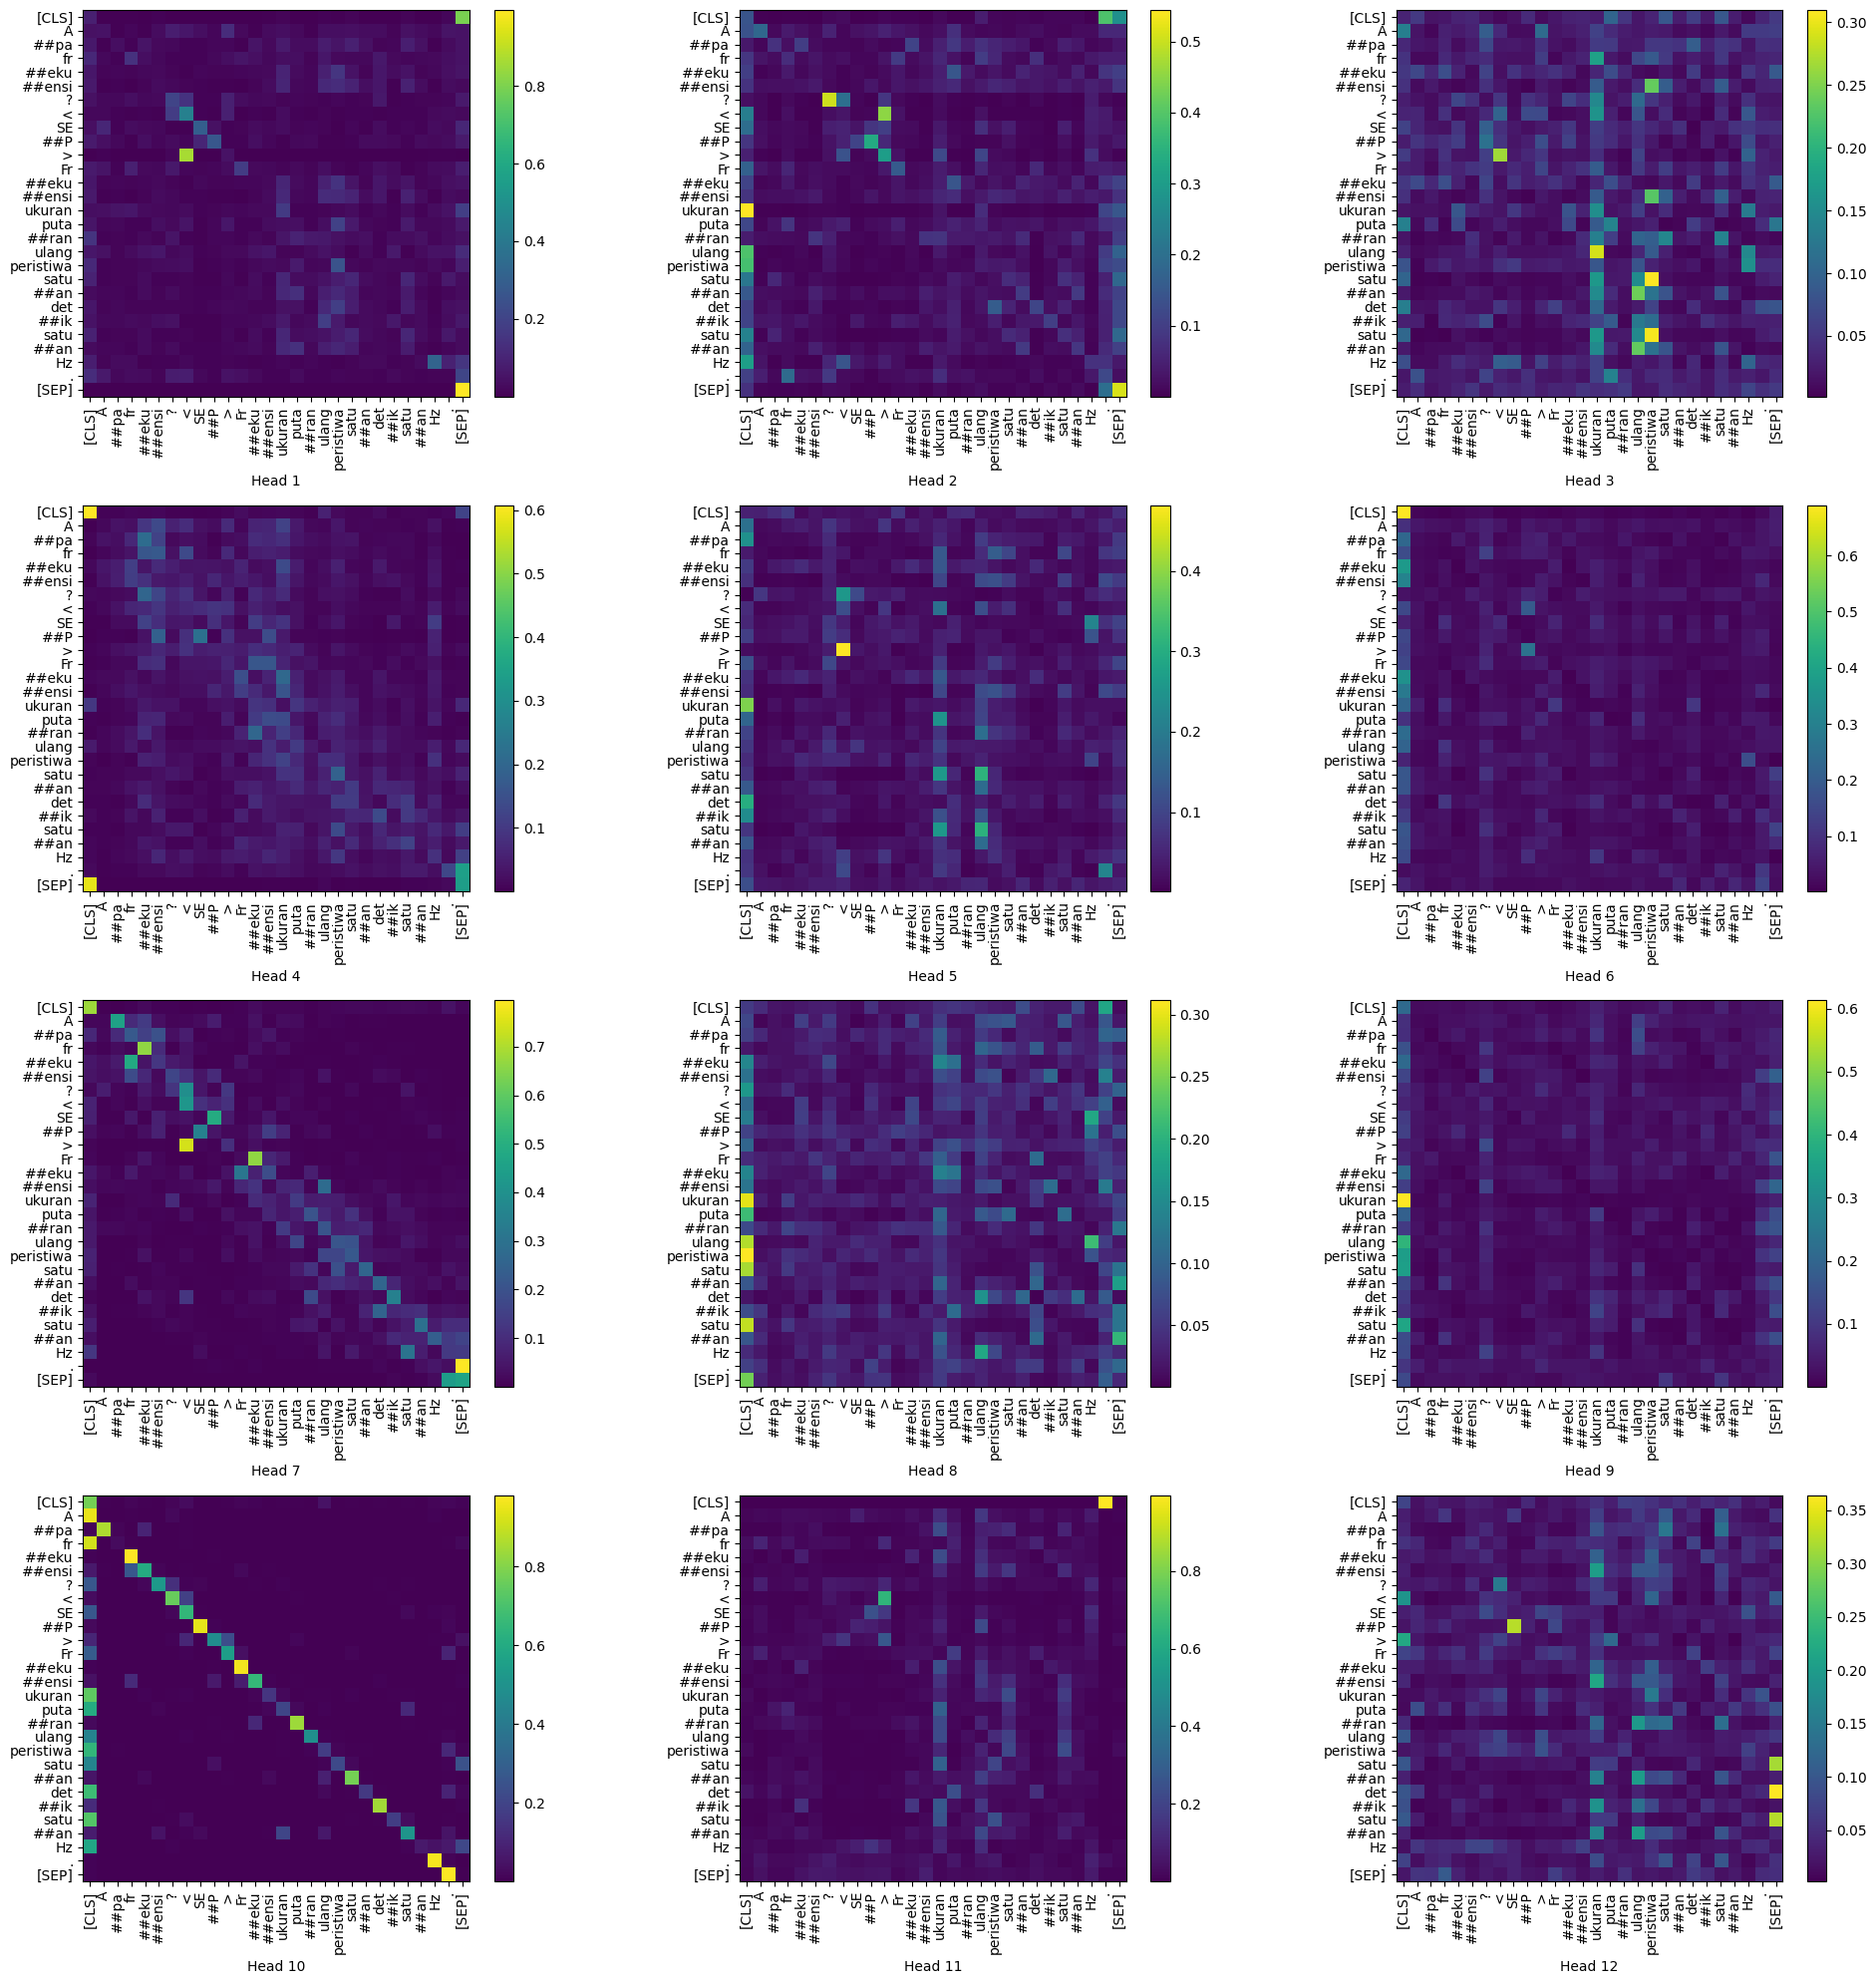

In [70]:
visualize_token2token_scores(output_attentions_all[0].squeeze().detach().cpu().numpy(), tokens)